# Generative Adversarial Networks tutorial
based on tutorial by Siraj Raval:
https://www.youtube.com/watch?v=0VPQHbMvGzg

In [18]:
import tensorflow as tf #machine learning
import numpy as np #matrix math
import datetime #logging the time for model checkpoints and training
import matplotlib.pyplot as plt #visualize results
%matplotlib inline

#Step 1 - Collect dataset
#MNIST - handwritten character data ~50k training and validation images + labels, 10k testing.
from tensorflow.examples.tutorials.mnist import input_data
#will ensure that the correct data has been downloaded to your
#local training folder and then unpack that data to return a dictionary of DataSet instances.
mnist = input_data.read_data_sets("MNIST_data/")


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


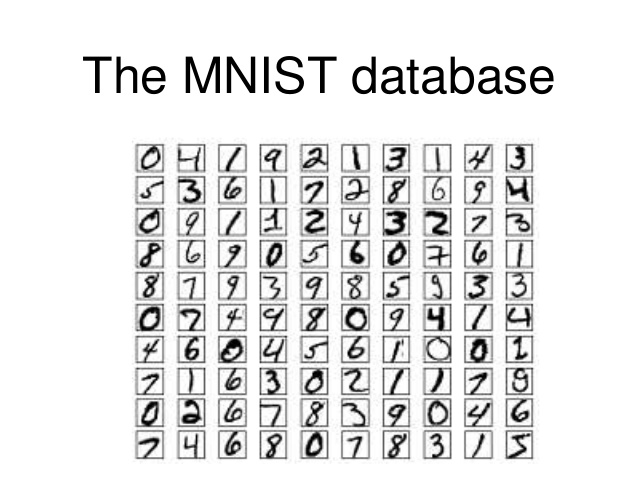

In a clever structure ...
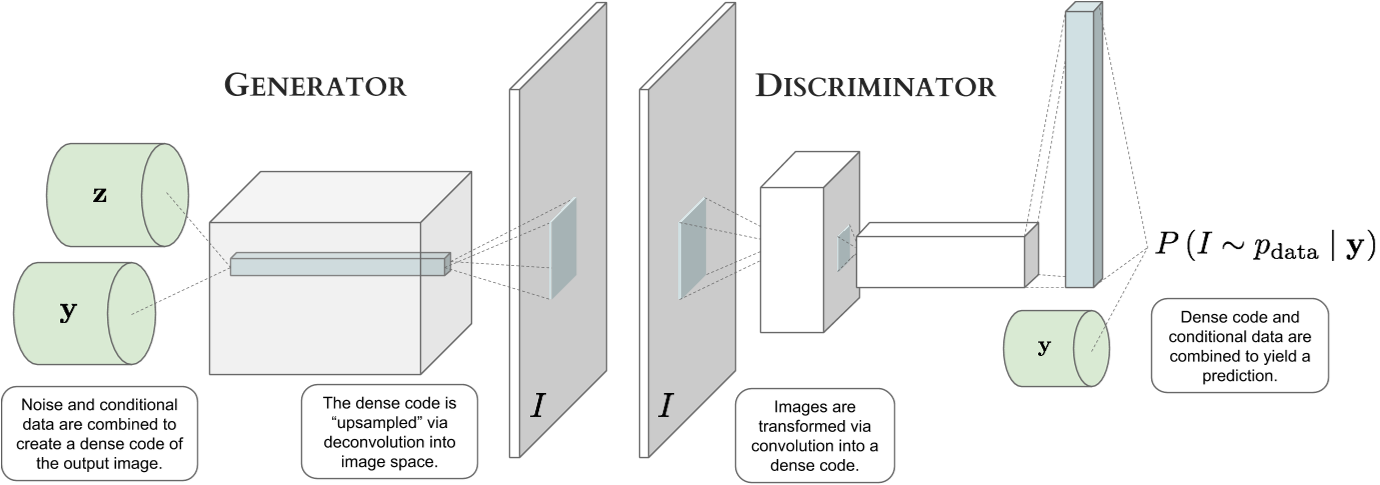

In [19]:
def discriminator(x_image, reuse=False):
    if (reuse):
        tf.get_variable_scope().reuse_variables()

    # First convolutional and pool layers
    # These search for 32 different 5x5 pixel features
    #We'll start off by passing the image through a convolutional layer.
    #First, we create our weight and bias variables through tf.get_variable.
    #Our first weight matrix (or filter) will be of size 5x5 and will have an output depth of 32.
    #It will be randomly initialized from a normal distribution
    d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer = tf.truncated_normal_initializer(stddev=0.02))
    #tf.constant_init generates tensors with constant values.
    d_b1 = tf.get_variable('d_b1', [32], initializer = tf.constant_initializer(0))
    #tf.nn.conv2d() is the Tensorflow's function for a common convolution.
    #It takes in 4 arguments. The first is the input volume (our 28 x 28 x 1 image in this case).
    #The next argument is the filter/weight matrix. Finally, you can also change the stride and
    #padding of the convolution. Those two values affect the dimensions of the output volume.
    #"SAME" tries to pad evenly left and right, but if the amount of columns to be added is odd,
    #it will add the extra column to the right,
    #strides = [batch, height, width, channels]
    d1 = tf.nn.conv2d(input = x_image, filter = d_w1, strides = [1, 1, 1, 1], padding = 'SAME')
    #add the bias
    dl = d1 + d_b1
    #squash with nonlinearity (ReLU)
    d1 = tf.nn.relu(d1)
    #An average pooling layer performs down-sampling by dividing the input into
    #rectangular pooling regions and computing the average of each region
    #It returns the averages for the pooling regions
    d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    #As with any convolutional neural network ,this module is repeated
    # Second convolutional and pool layers
    # These search for 64 different 5 x 5 pixel features
    d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer = tf.truncated_normal_initializer(stddev=0.02))
    d_b2 = tf.get_variable('d_b2', [64], initializer = tf.constant_initalizer(0))
    d2 = tf.nn.conv2d(input = d1, filter = d_w2, strides = [1, 1, 1, 1], padding = 'SAME')
    d2 = d2 + d_b2
    d2 = tf.nn.relu(d2)
    d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    
    #And then followed by a series of fully connected layers.
    #First fully connected layer
    d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer = tf.truncated_normal_initializer(stddev=0.02))
    d_b3 = tf.get_variable('d_b3', [1024], initalizer = tf.constant_initializer(0))
    d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
    d3 = tf.matmul(d3, d_w3)
    d3 = d3 + d_b3
    d3 = tf.nn.relu(d3)
    
    #The last fully-connected layer holds the output, such as the class scores.
    # Second fully connected layer
    d_w4 = tf.get_variable('d_w4', [1024, 1], initializer = tf.truncated_normal_initializer(stddev=0.02))
    d_b4 = tf.get_variable('d_b4', [1], initializer = tf.constant_initializer(0))
    
    #At the end of the network, we do a final matrix multiply and return the activation value.
    #For those of you comfortable with CNNs, this is just a simple binary classifier. Nothing fancy.
    d4 = tf.matmul(d3, d_w4) + d_b4
    # d4 dimensions: batch_size x 1
    
    return d4

And here's the generator When it's called, it starts by creating a batch of random noise from the latent space z, then passes it through a hanful of convolutions to produce a 28 x 28 image.

In [20]:
#You can think of the generator as being a kind of reverse ConvNet. With CNNs, the goal is to
#transform a 2- or 3-dimensional matrix of pixel values into a single probability. A generator,
#however, seeks to take a d-dimensional noise vector and upsample it to become a 28 x 28 image.
#ReLUs are then used to stabilize the outputs of each layer.
#Example of CNN blocks http://cs231n.github.io/convolutional-networks/#fc

#It takes random inputs, and eventually mapping them down to a [1, 28, 28] pixel to match the MNIS
#We begin by generating a dense 14x14 set of values, and then run through a handful of filters
#of varying sizes and numbers of channels.
#weight matrices get progressively smaller

def generator(batch_size, z_dim):
    z = tf.truncated_normal([batch_size, z_dim], mean = 0, stddev = 1, name = 'z')
    #First deconv block
    #3136 = 28 * 28 * 4
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype = tf.float32, initializer = tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer = tf.truncated_normal_initializer(stddev = 0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
    g1 = tf.nn.relu(g1)
    
    # Generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype = tf.float32, initializer = tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer = tf.truncated_normal_initializer(stddev = 0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides = [1, 2, 2, 1], padding = 'SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon = 1e-5, scope = 'bn2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])
    
    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype = tf.float32, initializer = tf.truncated_normal_initializer(stddev = 0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer = tf.truncated_normal_initializer(stddev = 0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides = [1, 2, 2, 1], padding = 'SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon = 1e-5, scope = 'bn3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])
    
    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype = tf.float32, initializer = tf.truncated_normal_initializer(stddev = 0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer = tf.truncated_normal_initializer(stddev = 0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides = [1, 2, 2, 1], padding = 'SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)
    
    # No batch normalization at the final layer, but we do add
    # a sigmoid activator to make the generated images crisper.
    # Dimensions of g4: batch_size x 28 x 28 x 1
    
    return g4


Here we set up our losses and optimizers.
$$c = \nabla \phi \sqrt{a^2 + b^2}$$
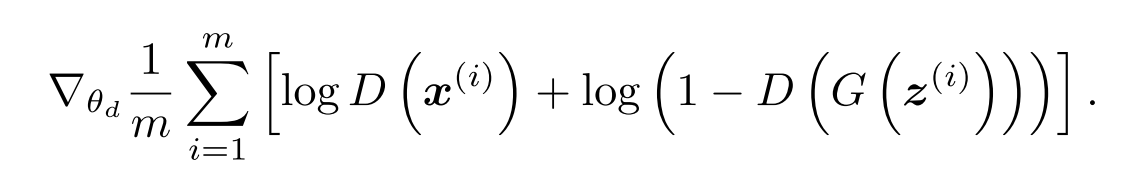
* The upside-down capital delta symbol denotes the gradient of the generator.

In [21]:
sess = tf.Session()

batch_size = 50
z_dimensions = 100

#feed image to D
x_placeholder = tf.placeholder('float', shape = [None, 28, 28, 28, 1], name = 'x_placeholder')
# x_placeholder is for feeding input images to the discriminator

#One of the trickiest parts about understanding GANs is that the loss function is a little bit more complex than that
#of a traditional CNN classifiers (For those, a simple MSE or Hinge Loss would do the trick).
#If you think back to the introduction, a GAN can be thought of as a zero sum minimax game.
#The generator is contantly improving to produce more and more realistic images, while the discriminator is
#trying to get better and better at distinguishing between real and generated images.
#This means that we need to formulate loss functions that affect both networks.
#Let's take a look at the inputs and outputs of our networks.

#(g(z))
Gz = generator(batch_size, z_dimensions)
#Gz holds the generated images

#d(x) - probs of real images
Dx = discriminator(x_placeholder)
#Dx holds the discriminator's prediction probabilities for real MNIST images

#d(g(z)) - probs of generated images
Dg = discriminator(Gz, reuse = True)
#Dg holds discriminator prediction probabilities for generated images

#Define generator's loss function
#So, let's first think about what we want out of our networks. We want the generator network to create
#images that will foll the discriminator. The generator wants the discriminator to output 1 (positive example).
#Therefore, we want to compute the loss between the Dg and label of 1. This can be done through
#the tf.nn.sigmoid_cross_entropy_with_logits function. This means that the cross entropy loss will
#be taken between the two arguments. The "with_logits" component means that the function will operate
#on unscaled values. Basically, this means that instead of using a softmax function to squash the output
#activations to probablity values from 0 to 1, we simply return the unscaled value of the matrix multiplication.
#Take a look at the last line of our discriminator. There's no softmax or sigmoid layer at the end.
#The reduce mean function just takes the mean value of all of the components in the matrix returned by the
#cross-entropy function. This is just a way of reducing the loss to a single scalar value, instead of a vector or matrix.
#https://datascience.stackexchange.com/questions/9302/the-cross-entropy-error-function-in-neural-networks
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg)))

#Now, let's think about the discriminator's point of view. Its goal is to just get the correct labels
#(output 1 for each MNIST digit and 0 for the generated ones). We'd like to compute the loss between Dx
#and the correct label of 1 as well as the loss between Dg and the correct label of 0.
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.fill([batch_size, 1], 0.9)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))
d_loss = d_loss_real + d_loss_fake

tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]


# Train the discriminator
# Increasing from 0.001 ing Github version
with tf.variable_scope(tf.get_variable_scope(), reuse = False) as scope:
    #Next, we specify our two optimizers. In today's era of deep learning, Adam seems to be the best 
    #SGD optimizer as it utilizes adaptive learning rates and momentum.
    #We call Adam's minimize function and also specify the variables that we want it to update.
    
    #TANGENT: checkout distill.pub site - publishing ML papers that are visually appealing.
    d_trainer_fake = tf.train.AdamOptimizer(0.0001).minimize(d_loss_fake, var_list = d_vars)
    d_trainer_real = tf.train.AdamOptimizer(0.0001).minimize(d_loss_real, var_list = d_vars)
    
    # Train the generator
    # Decreasing from 0.004 in Github version
    g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list = g_vars)
    

ValueError: Variable g_w1 already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "E:\Artur\Development\Anaconda3\envs\MachineLearningPython3\lib\site-packages\tensorflow\python\framework\ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access
  File "E:\Artur\Development\Anaconda3\envs\MachineLearningPython3\lib\site-packages\tensorflow\python\framework\ops.py", line 3392, in create_op
    op_def=op_def)
  File "E:\Artur\Development\Anaconda3\envs\MachineLearningPython3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
